In [54]:
import os
import time
import json
import numpy as np
import pandas as pd
from openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from dotenv import load_dotenv
load_dotenv()



True

In [55]:
# Create a small product dataset
products = [
    {"name": "Boho Dress", "desc": "Flowy maxi dress, earthy tones — bohemian festival vibes"},
    {"name": "Energetic Bomber", "desc": "Neon-trim bomber jacket, urban and confident"},
    {"name": "Cozy Knit Sweater", "desc": "Soft oversized knit for cozy home days"},
    {"name": "Tailored Blazer", "desc": "Sharp lines, office smart-casual look"},
    {"name": "Sport Luxe Leggings", "desc": "Glossy high-waist leggings for active wear"},
    {"name": "Vintage Tee", "desc": "Retro print tee with relaxed weekend style"},
    {"name": "Silk Slip Skirt", "desc": "Elegant silk skirt for soft evening vibes"},
]

df = pd.DataFrame(products)
df

,name,desc
0,Boho Dress,"Flowy maxi dress, earthy tones — bohemian fest..."
1,Energetic Bomber,"Neon-trim bomber jacket, urban and confident"
2,Cozy Knit Sweater,Soft oversized knit for cozy home days
3,Tailored Blazer,"Sharp lines, office smart-casual look"
4,Sport Luxe Leggings,Glossy high-waist leggings for active wear
5,Vintage Tee,Retro print tee with relaxed weekend style
6,Silk Slip Skirt,Elegant silk skirt for soft evening vibes


In [56]:
client = OpenAI()  # automatically reads key from environment

def get_embedding(text):
    try:
        # Try using OpenAI embedding model
        response = client.embeddings.create(
            model="text-embedding-ada-002",
            input=text
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Using TF-IDF fallback for: {text[:30]}...")
        # Simple fallback using TF-IDF
        global vectorizer
        if "vectorizer" not in globals():
            vectorizer = TfidfVectorizer(stop_words="english")
            vectorizer.fit(df["desc"])
        vec = vectorizer.transform([text]).toarray()[0]
        # Pad/truncate to 1536 dims (same as ada-002)
        if vec.shape[0] < 1536:
            vec = np.pad(vec, (0, 1536 - vec.shape[0]))
        else:
            vec = vec[:1536]
        return vec.tolist()

df["embedding"] = [get_embedding(t) for t in tqdm(df["desc"], desc="Creating embeddings")]
print("✅ Embeddings created successfully!")

Creating embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]

✅ Embeddings created successfully!


In [57]:
def vibe_matcher(query, top_k=3):
    """
    Takes a user 'vibe' text query and returns the top_k matching fashion items.
    """
    # Embed the query using the same function
    q_emb = np.array(get_embedding(query))
    all_emb = np.vstack(df["embedding"].values)

    # Compute cosine similarity
    sims = cosine_similarity([q_emb], all_emb)[0]
    df_result = df.copy()
    df_result["similarity"] = sims

    # Sort and return top results
    top_results = df_result.sort_values("similarity", ascending=False).head(top_k)
    return top_results

In [59]:
# Test a few example vibe queries
queries = [
    "energetic urban chic",
    "cozy minimal home outfit",
    "soft elegant evening wear"
]

for q in queries:
    print(f"\nQuery: {q}")
    top_items = vibe_matcher(q)
    for i, row in top_items.iterrows():
        print(f"{i+1}. {row['name']} — {row['desc']} (score: {row['similarity']:.3f})")


Query: energetic urban chic
2. Energetic Bomber — Neon-trim bomber jacket, urban and confident (score: 0.868)
4. Tailored Blazer — Sharp lines, office smart-casual look (score: 0.828)
6. Vintage Tee — Retro print tee with relaxed weekend style (score: 0.821)

Query: cozy minimal home outfit
3. Cozy Knit Sweater — Soft oversized knit for cozy home days (score: 0.882)
6. Vintage Tee — Retro print tee with relaxed weekend style (score: 0.836)
7. Silk Slip Skirt — Elegant silk skirt for soft evening vibes (score: 0.835)

Query: soft elegant evening wear
7. Silk Slip Skirt — Elegant silk skirt for soft evening vibes (score: 0.917)
4. Tailored Blazer — Sharp lines, office smart-casual look (score: 0.856)
1. Boho Dress — Flowy maxi dress, earthy tones — bohemian festival vibes (score: 0.842)



📈 Evaluation Results:

                       query  best_similarity  good_match  latency_sec
0       energetic urban chic         0.867482        True     0.536112
1   cozy minimal home outfit         0.882205        True     0.404361
2  soft elegant evening wear         0.917083        True     0.437974


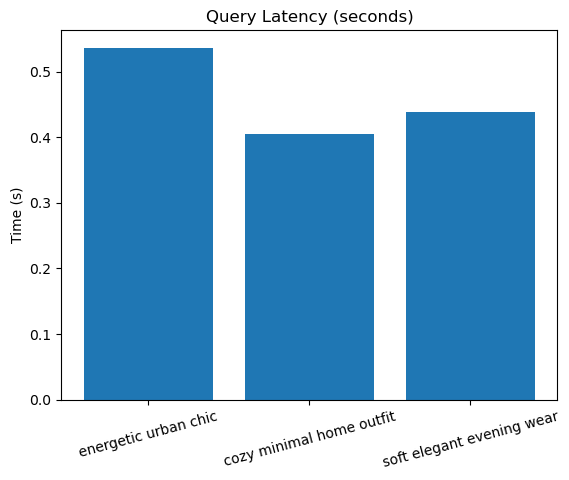

In [60]:
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt

results = []
for q in queries:
    start = timer()
    top = vibe_matcher(q)
    end = timer()
    best = float(top["similarity"].max())
    results.append({
        "query": q,
        "best_similarity": best,
        "good_match": best > 0.7,
        "latency_sec": end - start
    })

# Display metrics
metrics_df = pd.DataFrame(results)
print("\n📈 Evaluation Results:\n")
print(metrics_df)

# Plot latency for each query
plt.bar(metrics_df["query"], metrics_df["latency_sec"])
plt.title("Query Latency (seconds)")
plt.ylabel("Time (s)")
plt.xticks(rotation=15)
plt.show()